In [5]:
from IPython.display import display

from sympy import *
init_printing()

from monom import *

In [6]:
t, x, tau, h = symbols(r't, x, tau, h', real=True)
u = Function('u')(t, x)

In [7]:
pda_f, pda_v = (u,), (t, x)
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(1, 2), Rational(0, 1)

In [8]:
Monom.init([str(v) for v in pda_v], [str(f) for f in pda_f])
pda_var = dict(zip(pda_v, (Monom(i) for i in range(len(pda_v)))))
pda_fun = dict(zip(pda_f, (Monom(pos=i) for i in range(len(pda_f)))))

In [9]:
def T(f, i1, j1):
    return sum(sum(\
        diff(f, t, i, x, j)*(tau*(i1 - pda_p[0]))**i \
                             *(h*(j1 - pda_p[1]))**j/\
                 (factorial(i)*factorial(j))\
        for i in range(pda_n[0]))\
        for j in range(pda_n[1]))

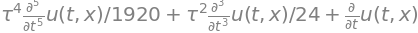

In [10]:
expand((T(u, 1, 0) - T(u, 0, 0))/(tau))

In [11]:
def clip(f):
    f = f.expand()
    r = []
    for i in range(pda_clp[0]):
        for j in range(pda_clp[1]):
            c = f.coeff(tau, i).coeff(h, j)
            if c and (\
            (pda_clp[0]-1 != i or j == 0) and \
            (pda_clp[1]-1 != j or i == 0)):
                r.append(((i, j), c))
    return r

def df2m(a):
    assert a.func == Derivative
    m = pda_fun[a.args[0]]
    for xi in a.args[1:]:
        if isinstance(xi, Symbol):
            m = m*pda_var[xi]
        else:
            m = m*pda_var[xi[0]]**xi[1]
    return m

def m2df(m):
    r = pda_f[m.position()]
    for i in range(len(m)):
        r = r.diff(pda_v[i], m[i])
    return r

def findDiv(a, d):
    r = None
    def find(a, r):
        if a.args:
            if a.func == Derivative and a.args[0] in pda_fun:
                m = df2m(a)
                if m.divisible(d) and (not r or m.cmp(r) > 0):
                    r = m
            else:
                for s in a.args:
                    r = find(s, r)
        return r
    return find(a, r)

def mult(a, s):
    r = []
    for mc in a:
        m = mc[0][0] + s[0], mc[0][1] + s[1]
        if m[0] < pda_clp[0] and m[1] < pda_clp[1] and\
           (pda_clp[0]-1 != m[0] or m[1] == 0) and \
           (pda_clp[1]-1 != m[1] or m[0] == 0):
            r.append((m, mc[1]))
    return r

def add(a, b):
    r, ia, ib = [], 0, 0
    iaend, ibend = len(a), len(b)
    while ia < iaend and ib < ibend:
        ma, mb = a[ia][0], b[ib][0]
        if ma[0] > mb[0]:
            c = 1
        elif ma[0] < mb[0]:
            c = -1
        elif ma[1] > mb[1]:
            c = 1
        elif ma[1] < mb[1]:
            c = -1
        else:
            c = 0
        
        if c == -1:
            r.append(a[ia])
            ia += 1
        elif c == 1:
            r.append(b[ib])
            ib += 1
        else:
            d = expand(a[ia][1] + b[ib][1])
            if d:
                r.append((ma, d))
            ia += 1
            ib += 1
    while ia < iaend:
        r.append(a[ia])
        ia += 1
    while ib < ibend:
        r.append(b[ib])
        ib += 1
    return r

def reduction(f1, f2, m, c, shift):
#     print(m, c, shift)
    f = mult(f2, shift)
    if not m:
        f = [(s, c*p) for s, p in f]
    else:
        f = [(s, c*p.diff(*m)) for s, p in f]
    return add(f1, f)

def NF(f, df, G, head=False):
    assert len(df) == len(G)
    ms = [df2m(d) for d in df]
    i = 0 if head else 1
    while i < len(f):
        shift, p = f[i]
        while True:
            r = None
            for l in range(len(ms)):
                r = findDiv(p, ms[l])
                if r:
                    break
            if not r: 
                break
            m = m2df(r)
            deg = p.as_poly(m).degree()
            c = p.coeff(m, deg)
            if deg > 1:
                c = p.coeff(m, deg)*m**(deg - 1)
            m = r/ms[l]
            d = []
            for k in range(len(pda_v)):
                if m[k] > 0:
                    d.append(pda_v[k])
                    if m[k] > 1:
                        d.append(m[k])
            f = reduction(f, G[l], tuple(d), -c/G[l][0][1].coeff(df[l]), shift)
            if i == len(f):
                break
            shift, p = f[i]
        i += 1
    return f

def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a in pda_f:
                return Symbol("%s" % a.func, real=True)
            elif a.func == Derivative:
                m = []
                for xi in a.args[1:]:
                    if isinstance(xi, Symbol):
                        m.append(str(xi))
                    else:
                        m.append(str(xi[0])*xi[1])
                return Symbol("%s_{%s}" % (a.args[0].func, "".join(m)), real=True)
            else:
                return a.func(*tuple(cmpct(s) for s in a.args))
    return cmpct(f)

def prn(a, p=None):
    for m, c in a:
        s = ""
        if m[0]:
            if m[0] == 1:
                s += "tau"
            else:
                s += "tau^%d" % m[0]
        if m[1]:
            if m[0]:
                s += " "
            if m[1] == 1:
                s += "h"
            else:
                s += "h^%d" % m[1]
        if s:
            print("%s =>" % s)
        if p:
            display(compact(c).collect(p, factor))
        else:
            display(compact(c))

rlen = []
def prnlatex(a, p=None):
    first = True
    for m, c in a:
        s = ""
        if m[0]:
            if m[0] == 1:
                s += r"\tau"
            else:
                s += r"\tau^%d" % m[0]
        if m[1]:
            if m[0]:
                s += " "
            if m[1] == 1:
                s += "h"
            else:
                s += r"h^%d" % m[1]
        if s:
            if first:
                first = False
                print(r"%s\Big(" % s)
            else:
                print(r" + %s\Big(" % s)
        if p:
            print(latex(compact(c).collect(p, factor)))
        else:
            print(latex(compact(c)))
        if first:
            first = False
        else:
            print(r"\Big)")
    rlen.append((len(a[1][1].args), len(a[2][1].args)))
    print(rlen[-1])

rep = (\
("u_{x}", "fi_x"),\
("u_{xx}", "fi_xx"),\
("u_{t}", "fi_t"),\
("u_{tx}", "fi_tx"),\
("u_{txx}", "fi_txx"),\
("u_{ttx}", "fi_ttx"),\
("u_{ttt}", "fi_ttt"),\
("u", "fi[2]"),\
)

def prnP(a):
    for m, c in a:
        s = ""
        if m[0]:
            if m[0] == 1:
                s += "tau"
            else:
                s += "tau^%d" % m[0]
        if m[1]:
            if m[0]:
                s += " "
            if m[1] == 1:
                s += "h"
            else:
                s += "h^%d" % m[1]
        if s:
            print("%s =>" % s)
            s = str(compact(c))
            for a, b in rep:
                s = s.replace(a, b)
            print(s)

In [12]:
D, k, xi = symbols('D, k, xi', real=True)

# решение в виде солитона с пьедесталом, которое 
обобщает решение Слюняева--Пелиновскогопри $D=0$ 
\begin{equation}\label{Blin_eq72a}
 u(t, x) = D + \frac{{k}^{2}}{1 + 
\mathrm{cosh}\left(k x - k(6 D + k^2) t\right)} .
\end{equation} 

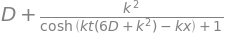

In [13]:
ex1 = D + k**2/(1 + cosh(k*x - k*(6*D +  k**2)*t))
ex1

Одно-солитонное решение представляет собой бегущую волну 
$\xi = k (x - 4 k^{2} t)$, зависящую от параметра $k$, которая распространяется без изменения формы и амплитуды~\cite[стр. 294]{Polyanin:2023}:
\begin{equation}\label{eq2}
u = \frac{2 k^{2}}{\cosh^{2}{\xi} }
\end{equation}

In [14]:
ex2 = 2*k**2*(1 - tanh(k*x - 4*k**3*t)**2)
ex2

In [15]:
def Dt(a):
    return (T(a, 1, 0) - T(a, -1, 0))/(2*tau)
def D2x(a, i):
    return (T(a, i, 1) - T(a, i, -1))/(2*h)
def D2xxx(a, i):
    return (T(a, i, 2) - 2*T(a, i, 1) + 2*T(a, i, -1) - T(a, i, -2))/(2*h**3)

N.J. Zabusky and M.D. Kruskal: Interaction of “solitons” in a collisionless plasma and the recurrence of initial states, Phys. Rev. Lett. 15, 240 (1965)

we explicit scheme with $O(\tau^2, h^2)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} -\dfrac{2 \tau}{h}\left(u^{n}_{i+1} + u^{n}_{i} + u^{n}_{i-1}\right) \left(u^{n}_{i+1} - u^{n}_{i-1}\right)\\
 & - \dfrac{\tau}{h^3}\left(u^{n}_{i+2} - 2u^{n}_{i+1} + 2u^{n}_{i-1} - u^{n}_{i-2}\right)
\end{align}

In [16]:
Monom.cmp = Monom.TOPdeglex
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(0, 2), Rational(0, 1)

In [17]:
F = clip(Dt(u) + 2*(T(u, 0, 1) + T(u, 0, 0) + T(u, 0, -1))*D2x(u, 0) + D2xxx(u, 0))
prn(F)
prnlatex(F)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 2 u_{xx} u_{x}
\Big)
 + \tau^2\Big(
\frac{u_{ttt}}{6}
\Big)
(3, 2)


In [18]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)
prnP(Ffda)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
3 u^{2} u_{x} + \frac{u u_{t}}{2} - \frac{u_{txx}}{4} - \frac{5 u_{xx} u_{x}}{2}
\Big)
 + \tau^2\Big(
\frac{u_{ttt}}{6}
\Big)
(4, 2)
h^2 =>
3*fi[2]**2*fi_x + fi[2]*fi_t/2 - fi_txx/4 - 5*fi_xx*fi_x/2
tau^2 =>
fi_ttt/6


In [19]:
display(Ffda[0][1].subs({u: ex1}).doit().simplify())

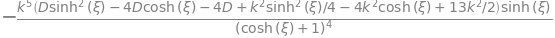

- \frac{k^{5} \left(D \sinh^{2}{\left(\xi \right)} - 4 D \cosh{\left(\xi \right)} - 4 D + \frac{k^{2} \sinh^{2}{\left(\xi \right)}}{4} - 4 k^{2} \cosh{\left(\xi \right)} + \frac{13 k^{2}}{2}\right) \sinh{\left(\xi \right)}}{\left(\cosh{\left(\xi \right)} + 1\right)^{4}}
-k**5*(D*sinh(xi)**2 - 4*D*cosh(xi) - 4*D + k**2*sinh(xi)**2/4 - 4*k**2*cosh(xi) + 13*k**2/2)*sinh(xi)/(cosh(xi) + 1)**4


In [20]:
res = Ffda[1][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).trigsimp()
display(res)
print(latex(res))
print(res)

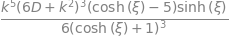

\frac{k^{5} \left(6 D + k^{2}\right)^{3} \left(\cosh{\left(\xi \right)} - 5\right) \sinh{\left(\xi \right)}}{6 \left(\cosh{\left(\xi \right)} + 1\right)^{3}}
k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)


In [21]:
res = Ffda[2][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(latex(res))
print(res)

In [22]:
display(Ffda[0][1].subs({u: ex2}).doit().simplify())

In [23]:
res = Ffda[1][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

8 k^{7} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(21 \tanh^{4}{\left(\xi \right)} - 24 \tanh^{2}{\left(\xi \right)} + 5\right) \tanh{\left(\xi \right)}
8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)*(21*tanh(xi)**4 - 24*tanh(xi)**2 + 5)*tanh(xi)


In [24]:
res = Ffda[2][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

- \frac{512 k^{11} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(3 \tanh^{2}{\left(\xi \right)} - 2\right) \tanh{\left(\xi \right)}}{3}
-512*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 2)*tanh(xi)/3


we explicit scheme with $O(\tau^2, h^2)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} -\dfrac{\alpha \tau}{h}u^{n}_{i}\left(u^{n}_{i+1} - u^{n}_{i-1}\right)\\
 & - \dfrac{\beta \tau}{h^3}\left(u^{n}_{i+2} - 2u^{n}_{i+1} + 2u^{n}_{i-1} - u^{n}_{i-2}\right) \tag{1.80}
\end{align}

for sufficiently small steps
\begin{equation}
\tau  \leq \dfrac{2h^3}{3\sqrt{3}} \cong 0.384 h^3 \tag{1.81}
\end{equation}

In [25]:
Monom.cmp = Monom.TOPdeglex
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(0, 2), Rational(0, 1)

In [26]:
F = clip(Dt(u) + 6*T(u, 0, 0)*D2x(u, 0) + D2xxx(u, 0))
prn(F)
prnlatex(F)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4}
\Big)
 + \tau^2\Big(
\frac{u_{ttt}}{6}
\Big)
(2, 2)


In [27]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)
prnP(Ffda)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
3 u^{2} u_{x} + \frac{u u_{t}}{2} - \frac{u_{txx}}{4} - \frac{9 u_{xx} u_{x}}{2}
\Big)
 + \tau^2\Big(
\frac{u_{ttt}}{6}
\Big)
(4, 2)
h^2 =>
3*fi[2]**2*fi_x + fi[2]*fi_t/2 - fi_txx/4 - 9*fi_xx*fi_x/2
tau^2 =>
fi_ttt/6


In [28]:
display(Ffda[0][1].subs({u: ex1}).doit().simplify())

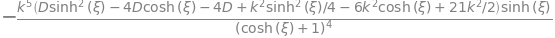

- \frac{k^{5} \left(D \sinh^{2}{\left(\xi \right)} - 4 D \cosh{\left(\xi \right)} - 4 D + \frac{k^{2} \sinh^{2}{\left(\xi \right)}}{4} - 6 k^{2} \cosh{\left(\xi \right)} + \frac{21 k^{2}}{2}\right) \sinh{\left(\xi \right)}}{\left(\cosh{\left(\xi \right)} + 1\right)^{4}}
-k**5*(D*sinh(xi)**2 - 4*D*cosh(xi) - 4*D + k**2*sinh(xi)**2/4 - 6*k**2*cosh(xi) + 21*k**2/2)*sinh(xi)/(cosh(xi) + 1)**4


In [29]:
res = Ffda[1][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).trigsimp()
display(res)
print(latex(res))
print(res)

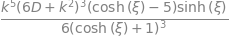

\frac{k^{5} \left(6 D + k^{2}\right)^{3} \left(\cosh{\left(\xi \right)} - 5\right) \sinh{\left(\xi \right)}}{6 \left(\cosh{\left(\xi \right)} + 1\right)^{3}}
k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)


In [30]:
res = Ffda[2][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(latex(res))
print(res)

In [31]:
display(Ffda[0][1].subs({u: ex2}).doit().simplify())

In [32]:
res = Ffda[1][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

8 k^{7} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(33 \tanh^{4}{\left(\xi \right)} - 40 \tanh^{2}{\left(\xi \right)} + 9\right) \tanh{\left(\xi \right)}
8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)*(33*tanh(xi)**4 - 40*tanh(xi)**2 + 9)*tanh(xi)


In [33]:
res = Ffda[2][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

- \frac{512 k^{11} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(3 \tanh^{2}{\left(\xi \right)} - 2\right) \tanh{\left(\xi \right)}}{3}
-512*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 2)*tanh(xi)/3


we explicit scheme with $O(\tau^2, h^4)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} 
    +\dfrac{\tau}{h}u^{n}_{i}\left(u^{n}_{i+2} - 8u^{n}_{i+1} + 8u^{n}_{i-1} - u^{n}_{i-2}\right)\\
 & + \dfrac{\tau}{4h^3}\left(u^{n}_{i+3} - 8u^{n}_{i+2} + 13u^{n}_{i+1} - 
                                   13u^{n}_{i-1} + 8u^{n}_{i-2} - u^{n}_{i-3}\right) \tag{1.82}
\end{align}

for sufficiently small steps
\begin{equation}
\tau  \leq \dfrac{108h^3}{(43 + 7\sqrt{73})\sqrt{10\sqrt{73} - 62}} \cong 0.216 h^3 \tag{1.83}
\end{equation}

In [34]:
def D4x(a, i):
    return -(T(a, i, 2) - 8*T(a, i, 1) + 8*T(a, i, -1) - T(a, i, -2))/(12*h)
def D4xxx(a, i):
    return -(T(a, i, 3) - 8*T(a, i, 2) + 13*T(a, i, 1) -\
             13*T(a, i, -1) + 8*T(a, i, -2) - T(a, i, -3))/(8*h**3)

In [35]:
Monom.cmp = Monom.TOPdeglex
pda_n, pda_clp = (6, 8), (3, 5)
pda_p = Rational(0, 2), Rational(0, 1)

In [36]:
F = clip(Dt(u) + 6*T(u, 0, 0)*D4x(u, 0) + D4xxx(u, 0))
prn(F)
prnlatex(F)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120}
\Big)
 + \tau^2\Big(
\frac{u_{ttt}}{6}
\Big)
(2, 2)


In [37]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)
prnP(Ffda)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
\frac{27 u^{3} u_{x}}{5} + \frac{9 u^{2} u_{t}}{10} - \frac{u u_{txx}}{2} - \frac{171 u u_{xx} u_{x}}{5} - \frac{7 u_{ttx}}{120} - \frac{49 u_{tx} u_{x}}{20} - \frac{77 u_{t} u_{xx}}{20} - \frac{21 u_{x}^{3}}{2}
\Big)
 + \tau^2\Big(
\frac{u_{ttt}}{6}
\Big)
(8, 2)
h^4 =>
27*fi[2]**3*fi_x/5 + 9*fi[2]**2*fi_t/10 - fi[2]*fi_txx/2 - 171*fi[2]*fi_xx*fi_x/5 - 7*fi_ttx/120 - 49*fi_tx*fi_x/20 - 77*fi_t*fi_xx/20 - 21*fi_x**3/2
tau^2 =>
fi_ttt/6


In [38]:
display(Ffda[0][1].subs({u: ex1}).doit().simplify())

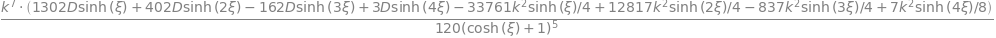

k**7*(1302*D*sinh(xi) + 402*D*sinh(2*xi) - 162*D*sinh(3*xi) + 3*D*sinh(4*xi) - 33761*k**2*sinh(xi)/4 + 12817*k**2*sinh(2*xi)/4 - 837*k**2*sinh(3*xi)/4 + 7*k**2*sinh(4*xi)/8)/(120*(cosh(xi) + 1)**5)


In [39]:
res = Ffda[1][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(res)

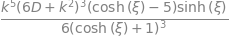

\frac{k^{5} \left(6 D + k^{2}\right)^{3} \left(\cosh{\left(\xi \right)} - 5\right) \sinh{\left(\xi \right)}}{6 \left(\cosh{\left(\xi \right)} + 1\right)^{3}}
k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(6*(cosh(xi) + 1)**3)


In [40]:
res = Ffda[2][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(latex(res))
print(res)

In [41]:
display(Ffda[0][1].subs({u: ex2}).doit().simplify())

In [42]:
res = Ffda[1][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

- \frac{32 k^{9} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(1935 \tanh^{6}{\left(\xi \right)} - 3780 \tanh^{4}{\left(\xi \right)} + 2184 \tanh^{2}{\left(\xi \right)} - 332\right) \tanh{\left(\xi \right)}}{15}
-32*k**9*(tanh(xi) - 1)*(tanh(xi) + 1)*(1935*tanh(xi)**6 - 3780*tanh(xi)**4 + 2184*tanh(xi)**2 - 332)*tanh(xi)/15


In [43]:
res = Ffda[2][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

- \frac{512 k^{11} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(3 \tanh^{2}{\left(\xi \right)} - 2\right) \tanh{\left(\xi \right)}}{3}
-512*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 2)*tanh(xi)/3


we Implicit   scheme with $O(\tau^2, h^2)$ approximation:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 +\frac{3}{2h}\left[{u}_{j}^{n}\left({u}_{j+1}^{n+1} - {u}_{j-1}^{n+1}\right) +
              {u}_{j}^{n+1}\left({u}_{j+1}^{n} - {u}_{j-1}^{n}\right)\right] + \\
 +\frac{1}{4h^{3}}\left(\left({u}_{j+2}^{n+1} -2{u}_{j+1}^{n+1} +2{u}_{j-1}^{n+1} -{u}_{j-2}^{n+1}\right) +
             \left({u}_{j+2}^{n} -2{u}_{j}^{n} +2{u}_{j-1}^{n} -{u}_{j-2}^{n}\right)\right)=0.  \tag{1.96}
\end{multline*}

In [44]:
def Dt(a):
    return (T(a, 1, 0) - T(a, 0, 0))/(tau)

In [45]:
Monom.cmp = Monom.TOPdeglex
pda_n, pda_clp = (6, 8), (3, 3)
pda_p = Rational(1, 2), Rational(0, 1)

In [46]:
F = clip(Dt(u) + 6*(T(u, 0, 0)*D2x(u, 1) + T(u, 1, 0)*D2x(u, 0))/2 + (D2xxx(u, 1) + D2xxx(u, 0))/2)
prn(F)
prnlatex(F)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4}
\Big)
 + \tau^2\Big(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} - \frac{3 u_{tx} u_{t}}{2}
\Big)
(2, 5)


In [47]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)
prnP(Ffda)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
3 u^{2} u_{x} + \frac{u u_{t}}{2} - \frac{u_{txx}}{4} - \frac{9 u_{xx} u_{x}}{2}
\Big)
 + \tau^2\Big(
- \frac{u_{ttt}}{12} - 3 u_{tx} u_{t}
\Big)
(4, 2)
h^2 =>
3*fi[2]**2*fi_x + fi[2]*fi_t/2 - fi_txx/4 - 9*fi_xx*fi_x/2
tau^2 =>
-fi_ttt/12 - 3*fi_tx*fi_t


In [48]:
display(Ffda[0][1].subs({u: ex1}).doit().simplify())

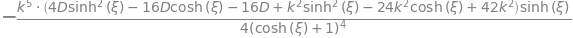

- \frac{k^{5} \cdot \left(4 D \sinh^{2}{\left(\xi \right)} - 16 D \cosh{\left(\xi \right)} - 16 D + k^{2} \sinh^{2}{\left(\xi \right)} - 24 k^{2} \cosh{\left(\xi \right)} + 42 k^{2}\right) \sinh{\left(\xi \right)}}{4 \left(\cosh{\left(\xi \right)} + 1\right)^{4}}
-k**5*(4*D*sinh(xi)**2 - 16*D*cosh(xi) - 16*D + k**2*sinh(xi)**2 - 24*k**2*cosh(xi) + 42*k**2)*sinh(xi)/(4*(cosh(xi) + 1)**4)


In [49]:
res = Ffda[1][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(latex(res))
print(res)

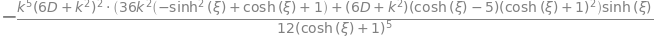

- \frac{k^{5} \left(6 D + k^{2}\right)^{2} \cdot \left(36 k^{2} \left(- \sinh^{2}{\left(\xi \right)} + \cosh{\left(\xi \right)} + 1\right) + \left(6 D + k^{2}\right) \left(\cosh{\left(\xi \right)} - 5\right) \left(\cosh{\left(\xi \right)} + 1\right)^{2}\right) \sinh{\left(\xi \right)}}{12 \left(\cosh{\left(\xi \right)} + 1\right)^{5}}
-k**5*(6*D + k**2)**2*(36*k**2*(-sinh(xi)**2 + cosh(xi) + 1) + (6*D + k**2)*(cosh(xi) - 5)*(cosh(xi) + 1)**2)*sinh(xi)/(12*(cosh(xi) + 1)**5)


In [50]:
res = Ffda[2][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(latex(res))
print(res)

In [51]:
display(Ffda[0][1].subs({u: ex2}).doit().simplify())

In [52]:
res = Ffda[1][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

8 k^{7} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(33 \tanh^{4}{\left(\xi \right)} - 40 \tanh^{2}{\left(\xi \right)} + 9\right) \tanh{\left(\xi \right)}
8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)*(33*tanh(xi)**4 - 40*tanh(xi)**2 + 9)*tanh(xi)


In [53]:
res = Ffda[2][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

\frac{256 k^{11} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(27 \tanh^{4}{\left(\xi \right)} - 33 \tanh^{2}{\left(\xi \right)} + 7\right) \tanh{\left(\xi \right)}}{3}
256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(27*tanh(xi)**4 - 33*tanh(xi)**2 + 7)*tanh(xi)/3


we Implicit scheme with $O(\tau^2, h^4)$ approximation:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 =\frac{3}{2h}\left[{u}_{j}^{n}\left({u}_{j+2}^{n+1} - 8{u}_{j+1}^{n+1} + 8{u}_{j-1}^{n+1} - {u}_{j-2}^{n+1}\right) 
              + {u}_{j}^{n+1}\left({u}_{j+2}^{n} - 8{u}_{j+1}^{n} + 8{u}_{j-1}^{n} - {u}_{j-2}^{n}\right)\right] + \\
 +\frac{1}{4h^{3}}\left(\left({u}_{j+3}^{n+1} - 8{u}_{j+2}^{n+1} + 13{u}_{j+1}^{n+1} 
                                  - 13{u}_{j-1}^{n+1} + 8{u}_{j-2}^{n+1} - {u}_{j-3}^{n+1}\right) +
             \left({u}_{j+3}^{n} - 8{u}_{j+2}^{n} + 13{u}_{j+1}^{n} 
                                  - 13{u}_{j-1}^{n} + 8{u}_{j-2}^{n} - {u}_{j-3}^{n}\right)\right).  \tag{1.84}
\end{multline*}

In [54]:
Monom.cmp = Monom.TOPdeglex
pda_n, pda_clp = (6, 8), (3, 5)
pda_p = Rational(1, 2), Rational(0, 1)

In [55]:
F = clip(Dt(u) + 6*(T(u, 0, 0)*D4x(u, 1) + T(u, 1, 0)*D4x(u, 0))/2 + (D4xxx(u, 1) + D4xxx(u, 0))/2)
prn(F)
prnlatex(F)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120}
\Big)
 + \tau^2\Big(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} - \frac{3 u_{tx} u_{t}}{2}
\Big)
(2, 5)


In [56]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)
prnP(Ffda)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
\frac{27 u^{3} u_{x}}{5} + \frac{9 u^{2} u_{t}}{10} - \frac{u u_{txx}}{2} - \frac{171 u u_{xx} u_{x}}{5} - \frac{7 u_{ttx}}{120} - \frac{49 u_{tx} u_{x}}{20} - \frac{77 u_{t} u_{xx}}{20} - \frac{21 u_{x}^{3}}{2}
\Big)
 + \tau^2\Big(
- \frac{u_{ttt}}{12} - 3 u_{tx} u_{t}
\Big)
(8, 2)
h^4 =>
27*fi[2]**3*fi_x/5 + 9*fi[2]**2*fi_t/10 - fi[2]*fi_txx/2 - 171*fi[2]*fi_xx*fi_x/5 - 7*fi_ttx/120 - 49*fi_tx*fi_x/20 - 77*fi_t*fi_xx/20 - 21*fi_x**3/2
tau^2 =>
-fi_ttt/12 - 3*fi_tx*fi_t


In [57]:
display(Ffda[0][1].subs({u: ex1}).doit().simplify())

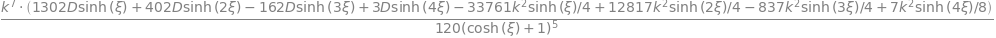

\frac{k^{7} \cdot \left(1302 D \sinh{\left(\xi \right)} + 402 D \sinh{\left(2 \xi \right)} - 162 D \sinh{\left(3 \xi \right)} + 3 D \sinh{\left(4 \xi \right)} - \frac{33761 k^{2} \sinh{\left(\xi \right)}}{4} + \frac{12817 k^{2} \sinh{\left(2 \xi \right)}}{4} - \frac{837 k^{2} \sinh{\left(3 \xi \right)}}{4} + \frac{7 k^{2} \sinh{\left(4 \xi \right)}}{8}\right)}{120 \left(\cosh{\left(\xi \right)} + 1\right)^{5}}
k**7*(1302*D*sinh(xi) + 402*D*sinh(2*xi) - 162*D*sinh(3*xi) + 3*D*sinh(4*xi) - 33761*k**2*sinh(xi)/4 + 12817*k**2*sinh(2*xi)/4 - 837*k**2*sinh(3*xi)/4 + 7*k**2*sinh(4*xi)/8)/(120*(cosh(xi) + 1)**5)


In [58]:
res = Ffda[1][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(latex(res))
print(res)

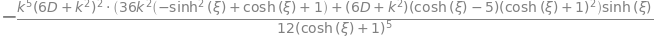

- \frac{k^{5} \left(6 D + k^{2}\right)^{2} \cdot \left(36 k^{2} \left(- \sinh^{2}{\left(\xi \right)} + \cosh{\left(\xi \right)} + 1\right) + \left(6 D + k^{2}\right) \left(\cosh{\left(\xi \right)} - 5\right) \left(\cosh{\left(\xi \right)} + 1\right)^{2}\right) \sinh{\left(\xi \right)}}{12 \left(\cosh{\left(\xi \right)} + 1\right)^{5}}
-k**5*(6*D + k**2)**2*(36*k**2*(-sinh(xi)**2 + cosh(xi) + 1) + (6*D + k**2)*(cosh(xi) - 5)*(cosh(xi) + 1)**2)*sinh(xi)/(12*(cosh(xi) + 1)**5)


In [59]:
res = Ffda[2][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(latex(res))
print(res)

In [60]:
display(Ffda[0][1].subs({u: ex2}).doit().simplify())

In [61]:
res = Ffda[1][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

- \frac{32 k^{9} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(1935 \tanh^{6}{\left(\xi \right)} - 3780 \tanh^{4}{\left(\xi \right)} + 2184 \tanh^{2}{\left(\xi \right)} - 332\right) \tanh{\left(\xi \right)}}{15}
-32*k**9*(tanh(xi) - 1)*(tanh(xi) + 1)*(1935*tanh(xi)**6 - 3780*tanh(xi)**4 + 2184*tanh(xi)**2 - 332)*tanh(xi)/15


In [62]:
res = Ffda[2][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

\frac{256 k^{11} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(27 \tanh^{4}{\left(\xi \right)} - 33 \tanh^{2}{\left(\xi \right)} + 7\right) \tanh{\left(\xi \right)}}{3}
256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(27*tanh(xi)**4 - 33*tanh(xi)**2 + 7)*tanh(xi)/3


В результате получим следующую разностную схему для уравнения~(1.18), 
аналогичную схеме Кранка--Николсона для уравнения теплопроводности
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 +3\frac{\left({u^2}_{j+1}^{n+1} - {u^2}_{j-1}^{n+1}\right) +
              \left({u^2}_{j+1}^{n} - {u^2}_{j-1}^{n}\right)}{4h} + \\
 + \frac{\left({u}_{j+2}^{n+1} -2{u}_{j+1}^{n+1} +2{u}_{j-1}^{n+1} -{u}_{j-2}^{n+1}\right) +
             \left({u}_{j+2}^{n} -2{u}_{j}^{n+1} +2{u}_{j-1}^{n} -{u}_{j-2}^{n}\right)}{4h^{3}}=0.
\end{multline*}

In [63]:
def Dt(a):
    return (T(a, 1, 0) - T(a, 0, 0))/(tau)

In [64]:
Monom.cmp = Monom.TOPlex
pda_n, pda_clp = (6, 6), (3, 3)
pda_p = Rational(0, 2), Rational(0, 1)

In [65]:
F = clip(Dt(u) + 3*(D2x(u**2, 1) + D2x(u**2, 0))/2 + (D2xxx(u, 1) + D2xxx(u, 0))/2)
prn(F)
prnlatex(F)

h^2 =>


tau =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
u u_{xxx} + \frac{u_{xxxxx}}{4} + 3 u_{xx} u_{x}
\Big)
 + \tau\Big(
3 u u_{tx} + \frac{u_{tt}}{2} + \frac{u_{txxx}}{2} + 3 u_{t} u_{x}
\Big)
 + \tau^2\Big(
\frac{3 u u_{ttx}}{2} + \frac{u_{ttt}}{6} + \frac{u_{ttxxx}}{4} + \frac{3 u_{tt} u_{x}}{2} + 3 u_{tx} u_{t}
\Big)
(3, 4)


In [66]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)
prnP(Ffda)

h^2 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^2\Big(
3 u^{2} u_{x} + \frac{u u_{t}}{2} - \frac{u_{txx}}{4} - \frac{3 u_{xx} u_{x}}{2}
\Big)
 + \tau^2\Big(
- \frac{u_{ttt}}{12}
\Big)
(4, 2)
h^2 =>
3*fi[2]**2*fi_x + fi[2]*fi_t/2 - fi_txx/4 - 3*fi_xx*fi_x/2
tau^2 =>
-fi_ttt/12


In [67]:
display(Ffda[0][1].subs({u: ex1}).doit().simplify())

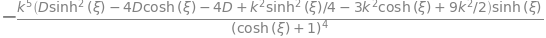

- \frac{k^{5} \left(D \sinh^{2}{\left(\xi \right)} - 4 D \cosh{\left(\xi \right)} - 4 D + \frac{k^{2} \sinh^{2}{\left(\xi \right)}}{4} - 3 k^{2} \cosh{\left(\xi \right)} + \frac{9 k^{2}}{2}\right) \sinh{\left(\xi \right)}}{\left(\cosh{\left(\xi \right)} + 1\right)^{4}}
-k**5*(D*sinh(xi)**2 - 4*D*cosh(xi) - 4*D + k**2*sinh(xi)**2/4 - 3*k**2*cosh(xi) + 9*k**2/2)*sinh(xi)/(cosh(xi) + 1)**4


In [68]:
res = Ffda[1][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).trigsimp()
display(res)
print(latex(res))
print(res)

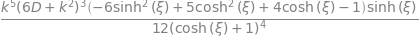

\frac{k^{5} \left(6 D + k^{2}\right)^{3} \left(- 6 \sinh^{2}{\left(\xi \right)} + 5 \cosh^{2}{\left(\xi \right)} + 4 \cosh{\left(\xi \right)} - 1\right) \sinh{\left(\xi \right)}}{12 \left(\cosh{\left(\xi \right)} + 1\right)^{4}}
k**5*(6*D + k**2)**3*(-6*sinh(xi)**2 + 5*cosh(xi)**2 + 4*cosh(xi) - 1)*sinh(xi)/(12*(cosh(xi) + 1)**4)


In [69]:
res = Ffda[2][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).combsimp()
display(res)
print(latex(res))
print(res)

In [70]:
display(Ffda[0][1].subs({u: ex2}).doit().simplify())

In [71]:
res = Ffda[1][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

8 k^{7} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(15 \tanh^{4}{\left(\xi \right)} - 16 \tanh^{2}{\left(\xi \right)} + 3\right) \tanh{\left(\xi \right)}
8*k**7*(tanh(xi) - 1)*(tanh(xi) + 1)*(15*tanh(xi)**4 - 16*tanh(xi)**2 + 3)*tanh(xi)


In [72]:
res = Ffda[2][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

\frac{256 k^{11} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(3 \tanh^{2}{\left(\xi \right)} - 2\right) \tanh{\left(\xi \right)}}{3}
256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 2)*tanh(xi)/3


Наша $O(\tau^2, h^4)$:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 - \frac{3}{24h}\left(\left({u^2}_{j+2}^{n+1} - 8{u^2}_{j+1}^{n+1} + 8{u^2}_{j-1}^{n+1} - {u^2}_{j-2}^{n+1}\right) 
              + \left({u^2}_{j+2}^{n} - 8{u^2}_{j+1}^{n} + 8{u^2}_{j-1}^{n} - {u^2}_{j-2}^{n}\right)\right) + \\
 - \frac{1}{16h^{3}}\left(\left({u}_{j+3}^{n+1} - 8{u}_{j+2}^{n+1} + 13{u}_{j+1}^{n+1} 
                                  - 13{u}_{j-1}^{n+1} + 8{u}_{j-2}^{n+1} - {u}_{j-3}^{n+1}\right) + \right. \\ \left.
             \left({u}_{j+3}^{n} - 8{u}_{j+2}^{n} + 13{u}_{j+1}^{n} 
                                  - 13{u}_{j-1}^{n} + 8{u}_{j-2}^{n} - {u}_{j-3}^{n}\right)\right)=0
\end{multline*}

In [73]:
def Dt(a):
    return (T(a, 1, 0) - T(a, 0, 0))/(tau)

In [74]:
Monom.cmp = Monom.TOPdeglex
pda_n, pda_clp = (6, 8), (3, 5)
pda_p = Rational(1, 2), Rational(0, 1)

In [75]:
F = clip(Dt(u) + 3*(D4x(u**2, 1) + D4x(u**2, 0))/2 + (D4xxx(u, 1) + D4xxx(u, 0))/2)
prn(F)
prnlatex(F)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
- \frac{u u_{xxxxx}}{5} - \frac{7 u_{xxxxxxx}}{120} - u_{xxxx} u_{x} - 2 u_{xxx} u_{xx}
\Big)
 + \tau^2\Big(
\frac{3 u u_{ttx}}{4} + \frac{u_{ttt}}{24} + \frac{u_{ttxxx}}{8} + \frac{3 u_{tt} u_{x}}{4} + \frac{3 u_{tx} u_{t}}{2}
\Big)
(4, 5)


In [76]:
Ffda = NF(F, [u.diff(x, 3)], [F], head=False)
prn(Ffda)
prnlatex(Ffda)
prnP(Ffda)

h^4 =>


tau^2 =>


6 u u_{x} + u_{t} + u_{xxx}
 + h^4\Big(
\frac{27 u^{3} u_{x}}{5} + \frac{9 u^{2} u_{t}}{10} - \frac{u u_{txx}}{2} - \frac{81 u u_{xx} u_{x}}{5} - \frac{7 u_{ttx}}{120} - \frac{29 u_{tx} u_{x}}{20} - \frac{37 u_{t} u_{xx}}{20} - \frac{9 u_{x}^{3}}{2}
\Big)
 + \tau^2\Big(
- \frac{u_{ttt}}{12}
\Big)
(8, 2)
h^4 =>
27*fi[2]**3*fi_x/5 + 9*fi[2]**2*fi_t/10 - fi[2]*fi_txx/2 - 81*fi[2]*fi_xx*fi_x/5 - 7*fi_ttx/120 - 29*fi_tx*fi_x/20 - 37*fi_t*fi_xx/20 - 9*fi_x**3/2
tau^2 =>
-fi_ttt/12


\frac{90 u u_{xx} u_{x}}{5} + \frac{20 u_{tx} u_{x}}{20} + \frac{40 u_{t} u_{xx}}{20} + \frac{3 u_{x}^{3}}{2}

In [86]:
21 - 18

In [77]:
display(Ffda[0][1].subs({u: ex1}).doit().simplify())

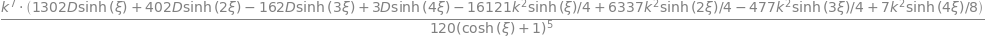

\frac{k^{7} \cdot \left(1302 D \sinh{\left(\xi \right)} + 402 D \sinh{\left(2 \xi \right)} - 162 D \sinh{\left(3 \xi \right)} + 3 D \sinh{\left(4 \xi \right)} - \frac{16121 k^{2} \sinh{\left(\xi \right)}}{4} + \frac{6337 k^{2} \sinh{\left(2 \xi \right)}}{4} - \frac{477 k^{2} \sinh{\left(3 \xi \right)}}{4} + \frac{7 k^{2} \sinh{\left(4 \xi \right)}}{8}\right)}{120 \left(\cosh{\left(\xi \right)} + 1\right)^{5}}
k**7*(1302*D*sinh(xi) + 402*D*sinh(2*xi) - 162*D*sinh(3*xi) + 3*D*sinh(4*xi) - 16121*k**2*sinh(xi)/4 + 6337*k**2*sinh(2*xi)/4 - 477*k**2*sinh(3*xi)/4 + 7*k**2*sinh(4*xi)/8)/(120*(cosh(xi) + 1)**5)


In [78]:
res = Ffda[1][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(latex(res))
print(res)

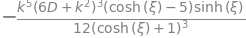

- \frac{k^{5} \left(6 D + k^{2}\right)^{3} \left(\cosh{\left(\xi \right)} - 5\right) \sinh{\left(\xi \right)}}{12 \left(\cosh{\left(\xi \right)} + 1\right)^{3}}
-k**5*(6*D + k**2)**3*(cosh(xi) - 5)*sinh(xi)/(12*(cosh(xi) + 1)**3)


In [79]:
res = Ffda[2][1].subs({u: ex1}).doit().subs({x: xi/k + (6*D + k**2)*t}).simplify()
display(res)
print(latex(res))
print(res)

In [80]:
display(Ffda[0][1].subs({u: ex2}).doit().simplify())

In [81]:
res = Ffda[1][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

- \frac{32 k^{9} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(945 \tanh^{6}{\left(\xi \right)} - 1800 \tanh^{4}{\left(\xi \right)} + 1014 \tanh^{2}{\left(\xi \right)} - 152\right) \tanh{\left(\xi \right)}}{15}
-32*k**9*(tanh(xi) - 1)*(tanh(xi) + 1)*(945*tanh(xi)**6 - 1800*tanh(xi)**4 + 1014*tanh(xi)**2 - 152)*tanh(xi)/15


In [82]:
res = Ffda[2][1].subs({u: ex2}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
print(latex(res))
print(res)

\frac{256 k^{11} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(3 \tanh^{2}{\left(\xi \right)} - 2\right) \tanh{\left(\xi \right)}}{3}
256*k**11*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 2)*tanh(xi)/3


In [83]:
for l in rlen[0::2]:
    print(l)

(3, 2)
(2, 2)
(2, 2)
(2, 5)
(2, 5)
(3, 4)
(4, 5)


In [84]:
for l in rlen[1::2]:
    print(l)

(4, 2)
(4, 2)
(8, 2)
(4, 2)
(8, 2)
(4, 2)
(8, 2)
